# 2. 미니섹터 지배력 분석?

- 서킷을 N개의 미니섹터로 쪼개서 분석
    - 고속 코너, 중속 코너 , 저속 코너 , 직선주로 에서의 속도 수준 분석
    - 시각화!!

## 2-1. How?

- 1. 공통 기준선 제작
    - 드라이버들마다 타는 드라이빙 라인이 미세하게 다르므로...
    - 서킷 전체를 N개의 구간으로 분할

- 2. 구간별 속도 비교
    - 각 구간에서 누가 평균 속도가 제일 빨랐는지 계산

- 3. 해당 구간의 트랙 지도(X , Y) 를 가장 빨랐던 드라이버의 색으로 색칠

In [3]:
import logging


# 또는 더 강력하게 모든 fastf1 관련 로그를 끄려면:
logging.getLogger('fastf1').setLevel(logging.ERROR)

In [1]:
import fastf1
import fastf1.plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 설정
fastf1.Cache.enable_cache('./cache')
fastf1.plotting.setup_mpl(misc_mpl_mods=False)

/home/hojin/airflow-env/lib/python3.12/site-packages/fastf1/plotting/_plotting.py:57: FutureWarning: The `misc_mpl_mods` argument was dropped from `.setup_mpl()` in version 3.6.0 and has no effect anymore. It will be removed in a future version of FastF1.
  warnings.warn(


In [5]:
# 세션 로드

session = fastf1.get_session(2025, 'Baku', 'R')
session.load(telemetry=True, weather=False, messages=False)

In [9]:
# 비교할 드라이버 선정

drivers = ['VER', 'RUS', 'SAI']
driver_colors = {d: fastf1.plotting.get_driver_color(d , session) for d in drivers}


# 데이터 전처리 >> 텔레메트리 수집 / 통합
tele_list = []

for driver in drivers:
    # 패랩 가져오기
    lap = session.laps.pick_drivers(driver).pick_fastest()

    # 텔레메트리 가져오기
    tel = lap.get_telemetry().add_distance()
    tel['Driver'] = driver
    tele_list.append(tel)

# 모든 드라이버 리스트 하나로 통합
all_tel = pd.concat(tele_list)

In [10]:
# 미니섹터 지정
## 전체 트랙을 15개의 구간으로 분할

total_chunks = 15

# 각 데이터 포인트가 몇 번째 청크에 속하는지 계산
# (현재 거리 / 전체 거리 * 청크 개수) 의 정수 부분
all_tel['MiniSector'] = pd.cut(all_tel['Distance'], total_chunks, labels=False)


# 지배자 계산 (Dominance Calculation)
# 각 미니 섹터별로 -> 각 드라이버의 평균 속도를 구함
sector_speed = all_tel.groupby(['MiniSector', 'Driver'])['Speed'].mean().reset_index()

# 각 미니 섹터에서 '가장 빠른 드라이버' 찾기 (idxmax 활용)
# pivot을 써서 행:섹터, 열:드라이버, 값:속도 로 변환 후 비교
speed_pivot = sector_speed.pivot(index='MiniSector', columns='Driver', values='Speed')
fastest_driver_per_sector = speed_pivot.idxmax(axis=1)

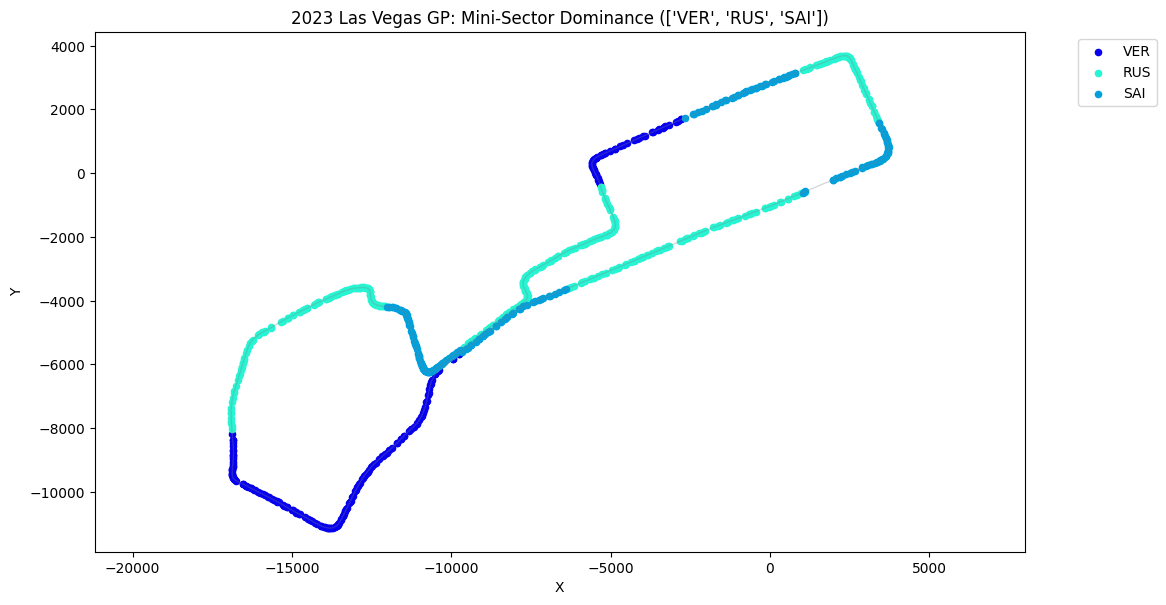

In [ ]:
# 7. 시각화 준비 (좌표 매핑)
# 트랙의 X, Y 좌표를 그리기 위해, 기준이 될 드라이버(예: 1등)의 텔레메트리를 가져옴
ref_tel = tele_list[0][['X', 'Y', 'Distance']].copy()
ref_tel['MiniSector'] = pd.cut(ref_tel['Distance'], total_chunks, labels=False)

# 기준 텔레메트리에 '가장 빠른 드라이버' 정보를 붙임 (Merge)
ref_tel['Fastest_Driver'] = ref_tel['MiniSector'].map(fastest_driver_per_sector)

# 8. 그래프 그리기
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))

# 트랙 전체를 얇은 회색선으로 먼저 그림 (바닥 깔기)
ax.plot(ref_tel['X'], ref_tel['Y'], color='gray', linestyle='-', linewidth=1, alpha=0.3)

# 섹터별로 색칠하기 (Scatter Plot 활용)
# Line으로 그리면 색깔 바뀔 때 끊겨 보여서, 점(Scatter)을 촘촘하게 찍는 게 꿀팁입니다.
for driver in drivers:
    driver_segment = ref_tel[ref_tel['Fastest_Driver'] == driver]
    if len(driver_segment) > 0:
        ax.scatter(driver_segment['X'], driver_segment['Y'], 
                   s=20, color=driver_colors[driver], label=driver)

# 꾸미기
plt.title(f"2025 Azerbaijan GP: Mini-Sector Dominance ({drivers})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 범례 바깥으로 뺌
plt.axis('equal') # 비율 유지
plt.show()